In [53]:
import pandas as pd
import numpy as np

url = "https://data.ct.gov/api/views/rybz-nyjw/rows.csv?accessType=DOWNLOAD"

# Read the data into a Pandas DataFrame
df = pd.read_csv(url)

# Drop irrelevant columns
df.drop([
    "Date Type", # Column with data type of date
    "Location if Other", # Column with location information
    "ResidenceCityGeo", # Column with geolocation information
    "InjuryCityGeo", # Column with geolocation information
    "DeathCityGeo" # Column with geolocation information
], axis=1, inplace=True)

# Drop non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df = df[numeric_cols]

# Rename columns
df.rename(columns={
    "Death Date": "Date",
    "Age": "Age",
    "Sex": "Gender",
    "Race": "Race",
    "Ethnicity": "Ethnicity",
    "Residence City": "Residence City",
    "Residence County": "Residence County",
    "Residence State": "Residence State",
    "Injury City": "Injury City",
    "Injury County": "Injury County",
    "Injury State": "Injury State",
    "Injury Place": "Injury Place",
    "Description of Injury": "Description of Injury",
    "Death City": "Death City",
    "Death County": "Death County",
    "Death State": "Death State",
    "Location": "Location",
    "Cause of Death": "Cause of Death",
    "Manner of Death": "Manner of Death",
    "Other Significant Conditions": "Other Significant Conditions",
    "Heroin": "Heroin",
    "Heroin death certificate (DC)": "Heroin death certificate (DC)",
    "Cocaine": "Cocaine",
    "Fentanyl": "Fentanyl",
    "Fentanyl Analogue": "Fentanyl Analogue",
    "Oxycodone": "Oxycodone",
    "Oxymorphone": "Oxymorphone",
    "Ethanol": "Ethanol",
    "Hydrocodone": "Hydrocodone",
    "Benzodiazepine": "Benzodiazepine",
    "Methadone": "Methadone",
    "Meth/Amphetamine": "Meth/Amphetamine",
    "Amphet": "Amphet",
    "Tramad": "Tramad",
    "Hydromorphone": "Hydromorphone",
    "Morphine (Not Heroin)": "Morphine (Not Heroin)",
    "Xylazine": "Xylazine",
    "Gabapentin": "Gabapentin",
    "Opiate NOS": "Opiate NOS",
    "Heroin/Morph/Codeine": "Heroin/Morph/Codeine",
    "Other Opioid": "Other Opioid",
    "Any Opioid": "Any Opioid",
    "Other": "Other"
}, inplace=True)

print(df.head())

    Age
0  37.0
1  37.0
2  28.0
3  26.0
4  41.0


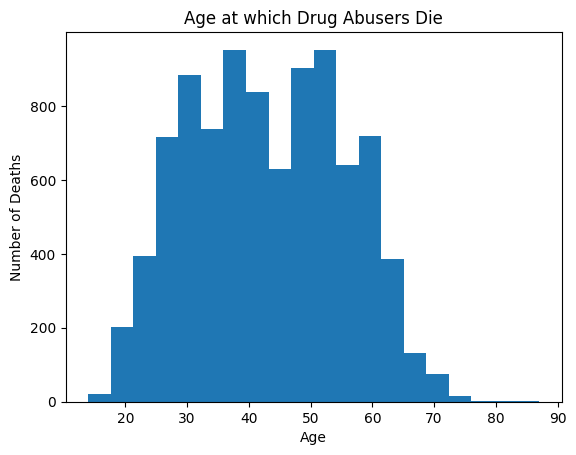

KeyError: 'Cocaine'

In [54]:
import matplotlib.pyplot as plt

# Create a histogram of ages at death
plt.hist(df['Age'], bins=20)
plt.title("Age at which Drug Abusers Die")
plt.xlabel("Age")
plt.ylabel("Number of Deaths")
plt.show()

# Create a histogram of deaths involving cocaine
plt.hist(df['Cocaine'], bins=20)
plt.title("Number of Deaths Involving Cocaine Use")
plt.xlabel("Number of Deaths")
plt.ylabel("Frequency")
plt.show()
